# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pmdarima as pm
import statsmodels.api as sm
import itertools
from matplotlib import style

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=InterpolationWarning)

In [5]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
plt.style.use('seaborn-v0_8')

# Helper Functions

In [7]:
def compare_item(item_code_1,item_code_2):
    '''This functions shows the descriptive information about the two comparing items.'''
    
    for c in o_col:
        if c not in ['PER_TAG','date']:
            print(c+':\t\t',df[df['ITEM_CODE']==item_code_1][c].unique(),df[df['ITEM_CODE']==item_code_2][c].unique())
            

In [8]:
def plot_timeseries(item,date,retailer):
    '''Plots trendline for given item and mentioned retailer.'''
    
    y=df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)]['VOLUME'].values
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y,'o-',color='green')
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume across the time',fontsize=20)
    plt.show()

In [9]:
def plot_corr(segment,retailer,annot=True):
    '''This functions plots the correlation heatmap for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    plt.figure(figsize=(15,12))
    sns.heatmap(dummy.corr(),annot=annot)
    plt.show()
    
def get_corr(df,segment,retailer):
    '''This functions shows the correlation coefficient values for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    
    return dummy.corr()

In [10]:
def get_highest(correlation_dataframe,correlation_value):
    '''This function returns the multi indexed dataframe showing items having highest correlation value'''
    
    New=pd.DataFrame()
    if correlation_dataframe.shape[1]>1:
        for col in correlation_dataframe.columns:
            item_1=[col]*correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].shape[0]
            item_2=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].index)
            item_1=[int(x) if type(x)==int else str(x) for x in item_1]
            item_2=[int(x) if type(x)==int else str(x) for x in item_2]
            corr=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].values)
            T=pd.DataFrame({'Item_1':item_1,
                           'Item_2':item_2,
                           'Corr':corr})
            T['Corr']=T['Corr'].apply(lambda x:x[0])
            New=pd.concat([New,T],ignore_index=True)
    else:
        T=pd.DataFrame({'Item_1':correlation_dataframe.index,
                           'Item_2':correlation_dataframe.columns,
                           'Corr':correlation_dataframe.iloc[0,0]})
        #T['Corr']=T['Corr'].apply(lambda x:x[0])
        New=pd.concat([New,T],ignore_index=True)
    
    New.set_index(["Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return New

In [11]:
def segment_wise_correlation(dataframe,retailer,corr_value):
    '''This functions returns the multi indexed dataframe containing items with high correlation value for 
    all the segments of a dataframe.'''
    
    
    T=pd.DataFrame()
    for seg in dataframe[dataframe['RETAILER']==retailer]['SEGMENT'].unique():
        New=get_highest(get_corr(seg,retailer),corr_value)
        New.reset_index(inplace=True)
        New['SEGMENT']=[seg]*New.shape[0]
        T=pd.concat([T,New],ignore_index=True)
    T.set_index(["SEGMENT","Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return T

In [12]:
def correlated_items_dataframe(df,item,segment,retailer,corr_value):
    '''This function returns dataframe containing Volume Sales of given correlated items.'''
    
    item_list=[int(x) for x in get_highest(get_corr(df,segment,retailer),corr_value).loc[item,:].index]
    N=pd.DataFrame()
    T=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
    T.reset_index(inplace=True,drop=True)
    T=T.rename(columns={T.columns[0]: item})
    if len(item_list)>1:
        for item in item_list:
            N=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
            N.reset_index(inplace=True,drop=True)
            N=N.rename(columns={N.columns[0]: item})
            T=pd.concat([T,N],axis=1)
    T.set_index(df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)]['date'].values,inplace=True)
    
    return T

In [13]:
def plot_correlated_trendlines(T,date):
    '''This function plots trendlines of given correlated items.'''
    
    item2_list=[int(col) for col in T.columns[1:-3]]
    y1=T[T.columns[0]]
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y1,'o-')
    leg=[T.columns[0]]
    
    for y in item2_list:
        ax.plot(x,T[[y]].values,'o-')
        leg.append(y)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume Trend across Time ',fontsize=20)
    plt.legend(leg)
    plt.show()

In [14]:
def plot_correlated_trendlines_separately(dataframe):
    '''This function plots trendlines of highly correlated items separately.'''
    
    fig, axes = plt.subplots(nrows=dataframe.shape[1], ncols=1, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        y=dataframe[dataframe.columns[i]]
        x=date
        if i==0:
            ax.plot(x,y,'.-',color='red' ,linewidth=0.4)
        else:
            ax.plot(x,y,'.-' ,linewidth=0.4)
        ax.set_title(dataframe.columns[i])
        plt.xticks(rotation=90,fontsize=14)
        #plt.xlabel('Dates',fontsize=20)
        plt.yticks(rotation=0,fontsize=14)
        #plt.ylabel(str(item),fontsize=14)
        ax.xaxis_date()     # interpret the x-axis values as dates
        fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
        #plt.grid(True)
        #plt.title('Volume Sales for {}'.format(item),fontsize=20)
        #ax.xaxis.set_ticks_position(None)
        #ax.yaxis.set_ticks_position(None)
        #ax.spines['Top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

In [15]:
def ADF_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series contains a unit root, it is not stationary.
       Alternative Hypothesis: There is no unit root.
       
       Low p-values are preferable. If the test returns a p-value BELOW the chosen significance level (e.g.0.05),
       we reject the null and conclude that the series does not contain a unit root.It appears to be stationary.
       '''
    adf_test = adfuller(x, autolag="aic")
    t_stat, p_value, _, _, _, _  = adf_test
    conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
    res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
    return res_dict

In [16]:
def KPSS_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series is stationary around a deterministic trend (trend-stationary)
       Alternative Hypothesis: The series has a unit root. It is non-stationary.
       
       High p-values are preferable. If the test returns a p-value ABOVE the chosen significance level (e.g.0.05),
       we conclude that the series appears to be atleast trend stationary.
       
    '''
    kpss_test = kpss(x)
    t_stat, p_value, _, critical_values  = kpss_test
    conclusion = "stationary" if p_value > ALPHA else "not stationary"
    res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
    return res_dict

In [17]:
def plot_stationarity(time_series, lags,model):
    
    y=time_series
    # decompose the time series into trend, seasonality and residuals
    decomp = seasonal_decompose(time_series, 
                                   model=model, 
                                   period=lags)
    # decomp.plot()
    # plt.show()
    trend = decomp.trend
    seas = decomp.seasonal
   
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))
    y.plot(ax=ax1)
    #ax1.set_title("Rolling 12-Month Temperature")
    ax1.set_title(y.name)
    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")
    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    # resid.plot(ax=ax4)
    # ax4.set_title("Residual Component")
    
    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);
    plt.tight_layout()

In [18]:
def get_segment(df,segment,retailer,date):
    item=df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique()[0]
    T=correlated_items_dataframe(df,item,segment,retailer,0)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [19]:
def get_items_from_segment(item,segment,retailer,date,corr_value=0.8):
    T=correlated_items_dataframe(item,segment,retailer,corr_value)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    #T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [20]:
def plot_timeseries_segment(dataframe,segment):
    x=get_dates(dataframe)
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,dataframe[segment].values,'o-',color='blue',linewidth=2.15)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('{} volume across the time'.format(segment),fontsize=20)
    plt.show()

In [21]:
def get_dates(dataframe):
    date=dataframe
    date.reset_index(inplace=True,drop=True)
    date=pd.to_datetime(date['date'])
    return date

In [22]:
def check_stationarity(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns[:-3]:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    N.set_index(['Item','Results'],inplace=True,drop=True)
    
    return N

In [23]:
def check_stationarity2(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    
    
    return N

In [24]:
def sarimax_gridsearch(ts, pdq, pdqs):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs)
                output = mod.fit() 
            except:
                print('pass')
                continue
            
            
            forecast=output.predict(start=0,end=109)
            ans.append([comb, combs, output.bic,MAPE(train.flatten(),forecast)])
            print('SARIMAX {} x {} : BIC Calculated ={}, MAPE Calculated= {}'.format(comb, combs, output.bic,MAPE(train.flatten(),forecast)))
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic','mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)[0:5]
    
    return ans_df

In [25]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def WAPE(y_true, y_pred, weighting = 'non-zero-flag'):
    w = {'non-zero-flag':np.where(y_true == 0, 0, 1), 
         'y':y_true,
        }.get(weighting)
    return mean_absolute_percentage_error(y_true, y_pred, w)

def TAPE(y_true, y_pred):
    total = np.sum(np.abs(y_true))
    pe = (y_pred - y_true)/total
    return np.sum(np.abs(pe)) if total > 0 else np.inf

def adj_PE(y_true, y_pred):
    return (y_pred - y_true)/(y_true + 1)

def PE(y_true, y_pred):
    return y_pred/y_true - 1

# Reading the data

In [26]:
df=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\DF_dataframe_final.csv')


##### Creating a dictionary containing description about the particular item

In [27]:
item_detail={}
for man in df['MANUFACTURER'].unique():
    for item in df[df['MANUFACTURER']==man]['ITEM_CODE'].unique():
        item_detail[item]=df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique()
        #print(item,df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique())

##### Creating a list containing names for all the object type columns

In [30]:
o_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='O':
        o_col.append(c)

##### Creating a list containing names for all the integer type columns

In [31]:
i_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='int':
        i_col.append(c)

##### Creating a list containing names for all the float type columns

In [32]:
f_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='float':
        f_col.append(c)

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [33]:
rem_f_col=[]
for i in f_col[:-117]:
    if df[i].describe()['std']==0 and df[i].describe()['mean']==0:
        rem_f_col.append(i)
        

##### Creating a list containing names for all the columns which contains SINE values       

In [34]:
sine_col=f_col[-117:]

##### Removing all the selected columns

In [35]:
f_col=[ele for ele in f_col if ele not in rem_f_col+sine_col]

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [36]:
zero_col=[]
for col in f_col:
    if df.shape[0]*0.95<=df[df[col]==0].shape[0]:
        zero_col.append(col)
        #print(col,df[df[col]==0].shape[0])

##### Removing all the selected columns

In [37]:
f_col=[ele for ele in f_col if ele not in zero_col]

In [38]:
o_col=[ele for ele in o_col if ele not in ['WEEK_END_DATE', 'WEEK_END_DATE_New']]

##### Date Timeline

In [40]:
date=get_dates(df[(df['ITEM_CODE']==9300701525033)&(df['RETAILER']=='Woolworths')][['date']])

-------
# Dealing only with ONGOING SKUs:

In [41]:
ongoing=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\EDA\Classified TimeSeries\Ongoing.csv',index_col='Unnamed: 0')

In [42]:
D=pd.DataFrame()
for i in ongoing.index:
    D=pd.concat([D,df[(df['ITEM_CODE']==ongoing['ITEM'].loc[i])&(df['RETAILER']==ongoing['RETAILER'].loc[i])]],
                axis=0,ignore_index=False)
                 

In [52]:
df1=D.copy()
L= ongoing.copy()

In [44]:
A=pd.DataFrame()
for segment in df['SEGMENT'].unique():
    for retailer in df[df['SEGMENT']==segment]['RETAILER'].unique():
        T=check_stationarity(get_segment(df,segment,retailer,date))
        diff_stat=[]
        tr_stat=[]
        non_stat=[]
        for item in T.index.levels[0]:
            if (T.loc[item,'Conclusion']['ADF']=='stationary') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Trend Stationary'.format(item,retailer))
                tr_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='stationary'):
                #print('{} in {} is Difference Stationary'.format(item,retailer))
                diff_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Non Stationary'.format(item,retailer))
                non_stat.append(item)
            else:
                pass
            
        a=pd.DataFrame({'RETAILER':[retailer]*(len(tr_stat)+len(diff_stat)+len(non_stat)),
          'SEGMENT':[segment]*(len(tr_stat)+len(diff_stat)+len(non_stat)),
          'ITEM':tr_stat+diff_stat+non_stat,
          'TREND STATIONARY':['Yes' if item in tr_stat else 'No' for item in (tr_stat+diff_stat+non_stat)],
          'DIFF. STATIONARY':['Yes' if item in diff_stat else 'No' for item in (tr_stat+diff_stat+non_stat)],
          'NON STATIONARY':['Yes' if item in non_stat else 'No' for item in (tr_stat+diff_stat+non_stat)]
          })
        A=pd.concat([A,a],ignore_index=True,axis=0)
        
   

In [45]:
A=A[~(A['SEGMENT']==A['ITEM'])]
A['ITEM']=A['ITEM'].apply(lambda x:int(x))

##### Ongoing Items

In [46]:
df1=df.copy()

In [53]:
df1=df1[df1['ITEM_CODE'].isin(L[L['STATUS']=='Ongoing']['ITEM'].unique())]

# Causality Analysis for Items in Other Car

 **Identifying Stationary time series in Other Car segment**

In [54]:
segment='Other Car'
retailer='Woolworths'

In [55]:
other_car_stat=[]
for item in L[(L['STATUS']=='Ongoing')&(L['SEGMENT']==segment)&(L['RETAILER']==retailer)]['ITEM'].unique():
    if item in A['ITEM'].unique():
        pass
    else:
        other_car_stat.append(item)

In [56]:
other_car_stat

[12844067194,
 12844090314,
 12844090321,
 12844092035,
 12844095937,
 9311412400014,
 9312790518346,
 9312790523401]

In [57]:
other_car=get_segment(df,segment,retailer,date)

###  12844067194

In [58]:
item=12844067194

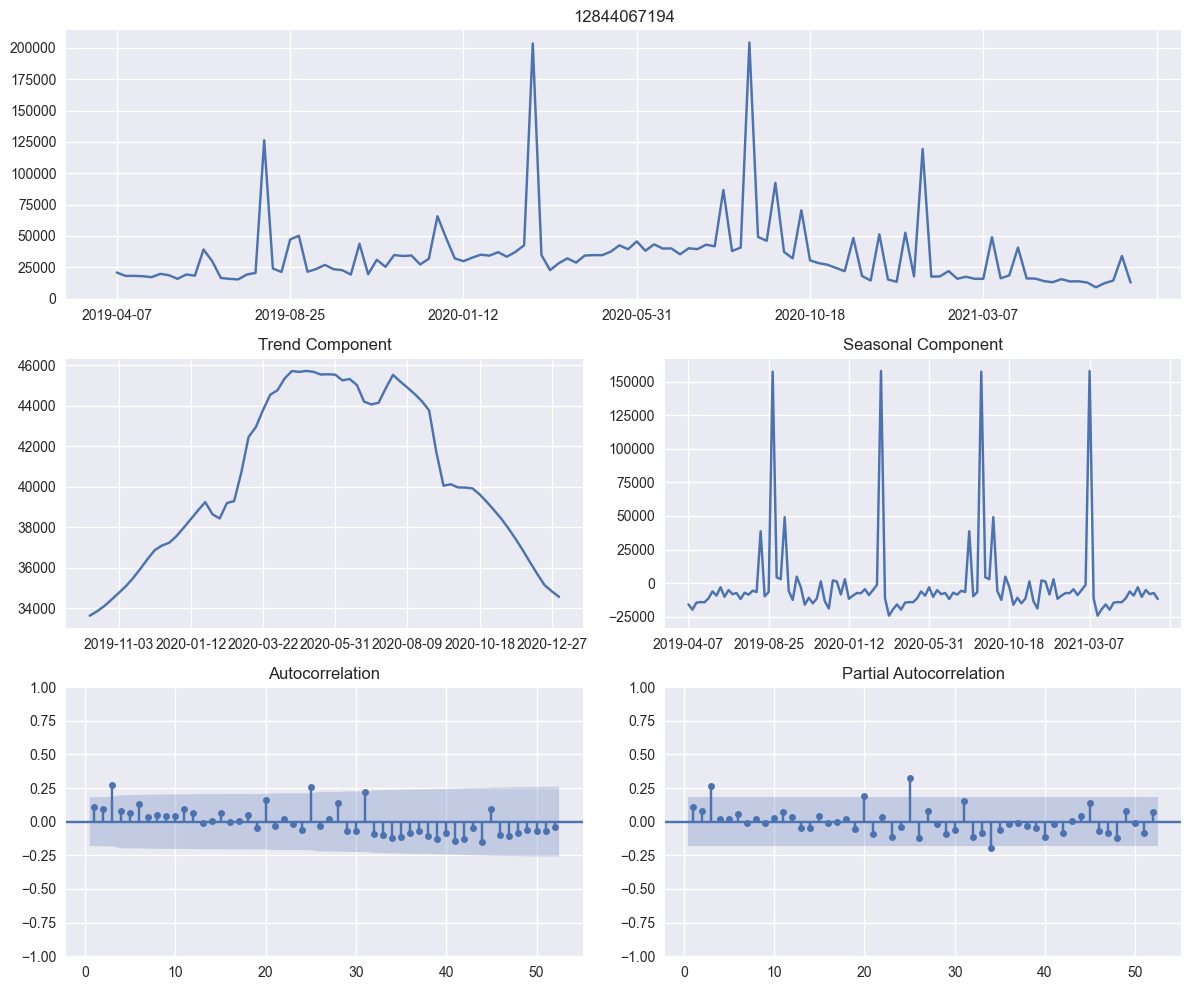

In [59]:
plot_stationarity(other_car[item],52,'additive')

In [60]:
other_car_item=other_car[[item]]

In [61]:
check_stationarity2(other_car_item.dropna())

,Item,Results,ADF,KPSS
0,12844067194,Test Statistics,-4.228,0.320
1,12844067194,p-value,0.001,0.100
2,12844067194,Differencing Required,False,False
3,12844067194,Conclusion,stationary,stationary


- **pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test**

In [62]:
n_adf = pm.arima.ndiffs(other_car_item[[item]], test="adf")
n_kpss = pm.arima.ndiffs(other_car_item[[item]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print("recommended order of first differencing for original data:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data:
ADF ndiff : 0
KPSS ndiff : 0


[None, None]

- **regular differencing: combine the OCSB and CH test results**

In [63]:
n_diff = max(n_adf, n_kpss)

In [64]:
description={}
description['ITEM']=item
description['SEGMENT']=segment
description['RETAILER']=retailer

### Forecasting using ARIMA

#### Model Fitting

##### Create Training and Test

In [65]:
train = other_car_item[[other_car_item.columns[0]]].values[:-8]
test = other_car_item[[other_car_item.columns[0]]].values[-8:]

In [66]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2584.537, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2678.206, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2625.842, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2652.516, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2586.167, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2587.408, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2650.963, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2611.777, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2588.493, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2584.254, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2582.867, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2581.444, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2582.712, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.514 seconds


In [67]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:                        SARIMAX   Log Likelihood               -1288.722
Date:                Fri, 12 Jul 2024   AIC                           2581.444
Time:                        03:23:37   BIC                           2586.845
Sample:                             0   HQIC                          2583.635
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.574e+04   5695.839      6.274      0.000    2.46e+04    4.69e+04
sigma2      8.782e+08   7.65e+07     11.487      0.000    7.28e+08    1.03e+09
Ljung-Box (L1) (Q):                   0.75   Jarque-

In [68]:
description['ARIMA']=model.order

------

#### Forecasting Time Series

In [69]:
forecast=model.predict(n_periods=8)

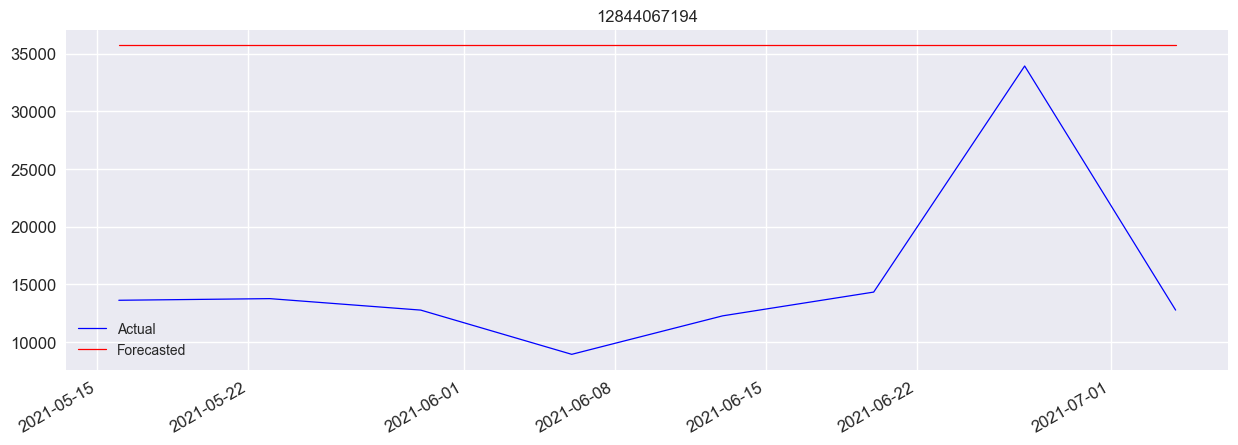

In [70]:
y1=test.flatten()
y0=forecast
x=date[-8:]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title(other_car_item.columns[0])
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Forecasted'],loc='lower left')
plt.show()

#### Diagonostic Checking

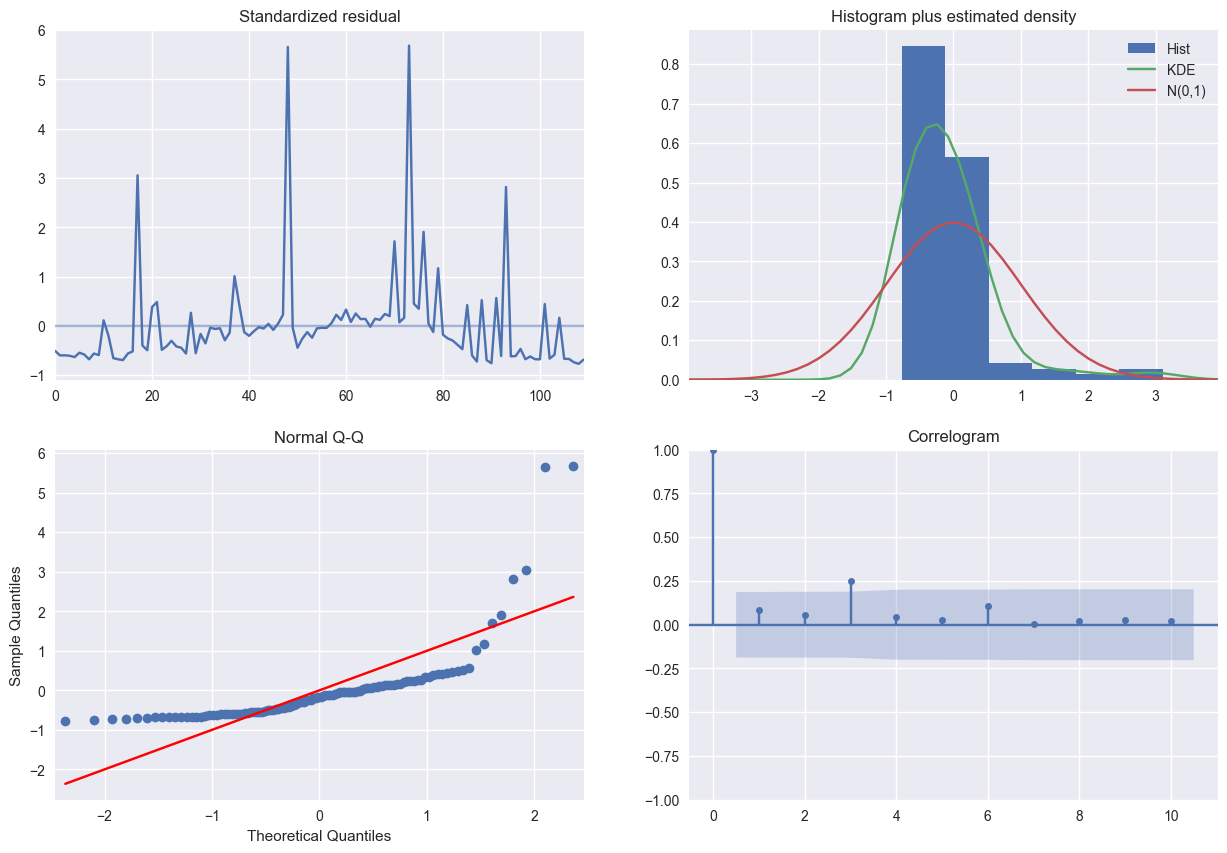

In [71]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

##### Durbin Watson Test for Autocorrelation among residuals

In [72]:
out = durbin_watson(model.resid())
description['Autocorrelation_ARIMA']=out
print("Autocorrelation among residual for {}".format(other_car_item.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 1.83


#### Error Metrics

In [73]:
description['MAPE_ARIMA']=MAPE(test.flatten(),forecast)
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))

For SKU: 12844067194 MAPE is : 165.73019948030657


In [74]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['RMSE_ARIMA']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 35738.17.
Root Mean Squared Error is :21662.95


### Forecasting using SARIMA

In [75]:
res=pd.DataFrame()
for seasonality in [4,12,52]:

    # Note: higher numbers will result in code taking much longer to run
    # Here we have it set to test p,d,q each = 0, 1 & 2

    # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
    d=range(0,2)
    p = q = range(0,2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    # Note: here we have 12 in the 's' position as we have monthly data
    # You'll want to change this according to your time series' frequency
    pdqs = [(x[0], x[1], x[2], seasonality) for x in list(itertools.product(p, d, q))]
    k=sarimax_gridsearch(train, pdq, pdqs)
    res=pd.concat([res,k],axis=0,ignore_index=True)

SARIMAX (0, 0, 0) x (0, 0, 0, 4) : BIC Calculated =2680.906571474833, MAPE Calculated= 100.0
SARIMAX (0, 0, 0) x (0, 0, 1, 4) : BIC Calculated =2663.4606791626206, MAPE Calculated= 74.2552809131077
SARIMAX (0, 0, 0) x (0, 1, 0, 4) : BIC Calculated =2559.5790558694553, MAPE Calculated= 59.575943986976995
SARIMAX (0, 0, 0) x (0, 1, 1, 4) : BIC Calculated =2511.682675711302, MAPE Calculated= 54.93757802810111
SARIMAX (0, 0, 0) x (1, 0, 0, 4) : BIC Calculated =2635.4060701565945, MAPE Calculated= 55.08963809336722
SARIMAX (0, 0, 0) x (1, 0, 1, 4) : BIC Calculated =2607.264334366874, MAPE Calculated= 51.59314807990098
SARIMAX (0, 0, 0) x (1, 1, 0, 4) : BIC Calculated =2534.715051151976, MAPE Calculated= 56.628984330823705
SARIMAX (0, 0, 0) x (1, 1, 1, 4) : BIC Calculated =2516.20187359047, MAPE Calculated= 55.43604894477227
SARIMAX (0, 0, 1) x (0, 0, 0, 4) : BIC Calculated =2657.917114036755, MAPE Calculated= 74.32707854918574
SARIMAX (0, 0, 1) x (0, 0, 1, 4) : BIC Calculated =2655.27048118

In [76]:
res.sort_values(by='mape',inplace=True)
res

,pdq,pdqs,bic,mape
5,"(1, 0, 1)","(0, 0, 1, 12)",2597.322,42.663
6,"(1, 0, 1)","(1, 0, 0, 12)",2597.324,42.686
0,"(1, 0, 1)","(1, 0, 1, 4)",2601.672,42.706
7,"(1, 0, 1)","(1, 0, 1, 12)",2601.644,42.721
1,"(1, 0, 1)","(0, 0, 1, 4)",2597.133,42.783
2,"(1, 0, 1)","(1, 0, 0, 4)",2597.149,42.784
3,"(1, 0, 1)","(0, 0, 0, 4)",2592.639,42.835
8,"(1, 0, 1)","(0, 0, 0, 12)",2592.639,42.835
10,"(1, 0, 1)","(0, 0, 0, 52)",2592.639,42.835
11,"(1, 0, 1)","(1, 0, 1, 52)",2602.040,42.838


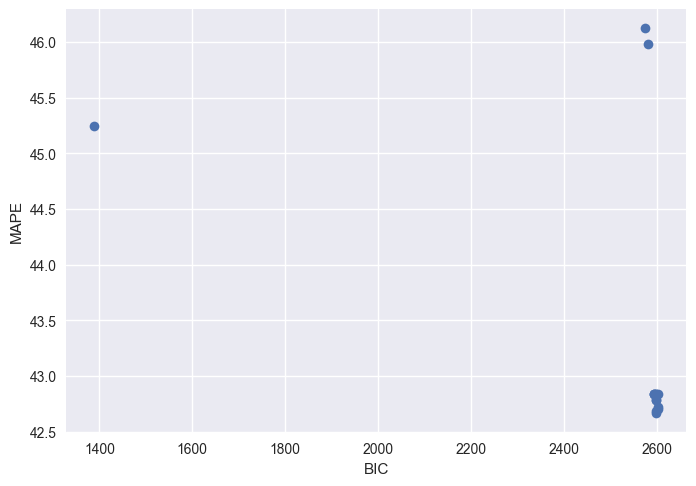

In [77]:
plt.plot(res['bic'],res['mape'],'o')
plt.xlabel('BIC')
plt.ylabel('MAPE')
plt.show()

In [78]:
p,d,q=res['pdq'].iloc[0]
ps,ds,qs,ss=res['pdqs'].iloc[0]

#### Model Fitting

In [79]:
model=sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(ps,ds,qs,ss))
results=model.fit()

In [80]:
model.seasonal_order

(0, 0, 1, 12)

In [81]:
description['SARIMA']=[model.order,model.seasonal_order]

#### Forecasting Time Series

In [82]:
forecast=results.predict(start=111,end=118)

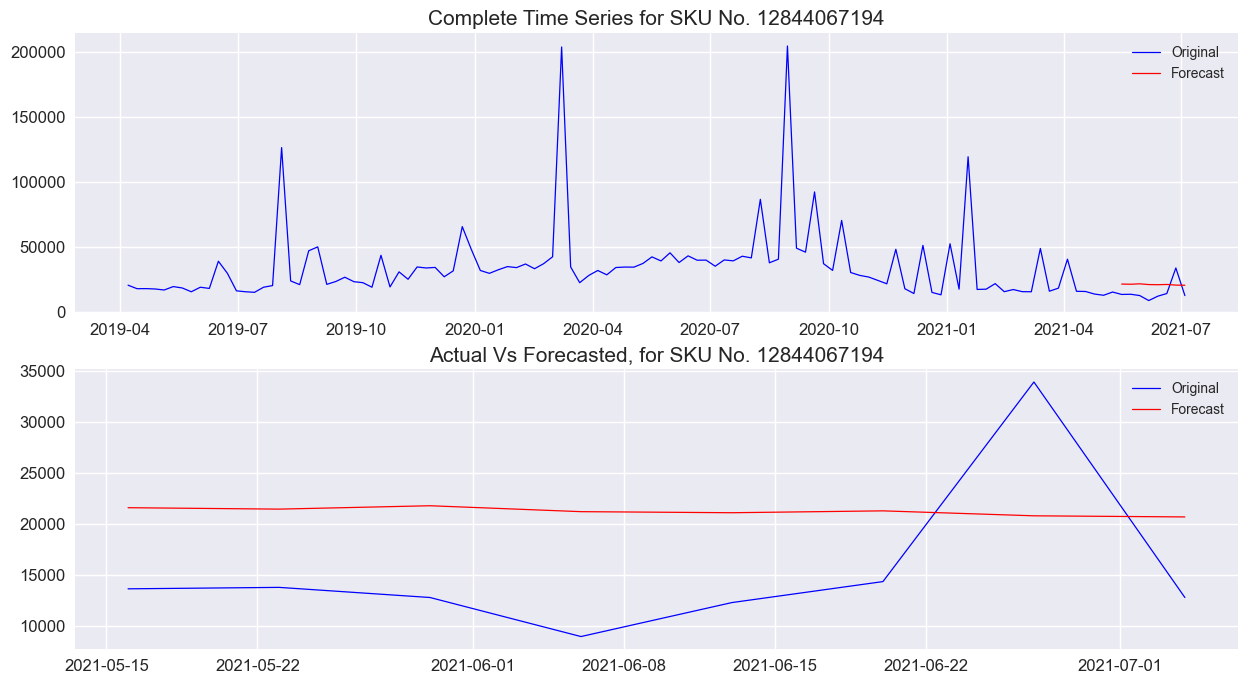

In [83]:
y1=other_car_item[other_car_item.columns[0]]
y0=forecast
x=date
y11=test.flatten()
y01=forecast
x1=date[-8:]
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(15,8))
axes[0].plot(x,y1,'-',color='blue' ,linewidth=0.9)
axes[0].plot(date[-8:],y0,'-',color='red' ,linewidth=0.9)
axes[0].set_title("Complete Time Series for SKU No. {}".format(other_car_item.columns[0]),fontsize=15)
axes[0].xaxis_date()
axes[0].tick_params(labelsize=12)
axes[0].legend(['Original','Forecast'])
axes[1].plot(x1,y11,'-',color='blue' ,linewidth=0.9)
axes[1].plot(x1,y01,'-',color='red' ,linewidth=0.9)
axes[1].set_title("Actual Vs Forecasted, for SKU No. {}".format(other_car_item.columns[0]),fontsize=15)
axes[1].xaxis_date()
axes[1].tick_params(labelsize=12)
axes[1].legend(['Original','Forecast'])
plt.show()

#### Diagonostic Checking

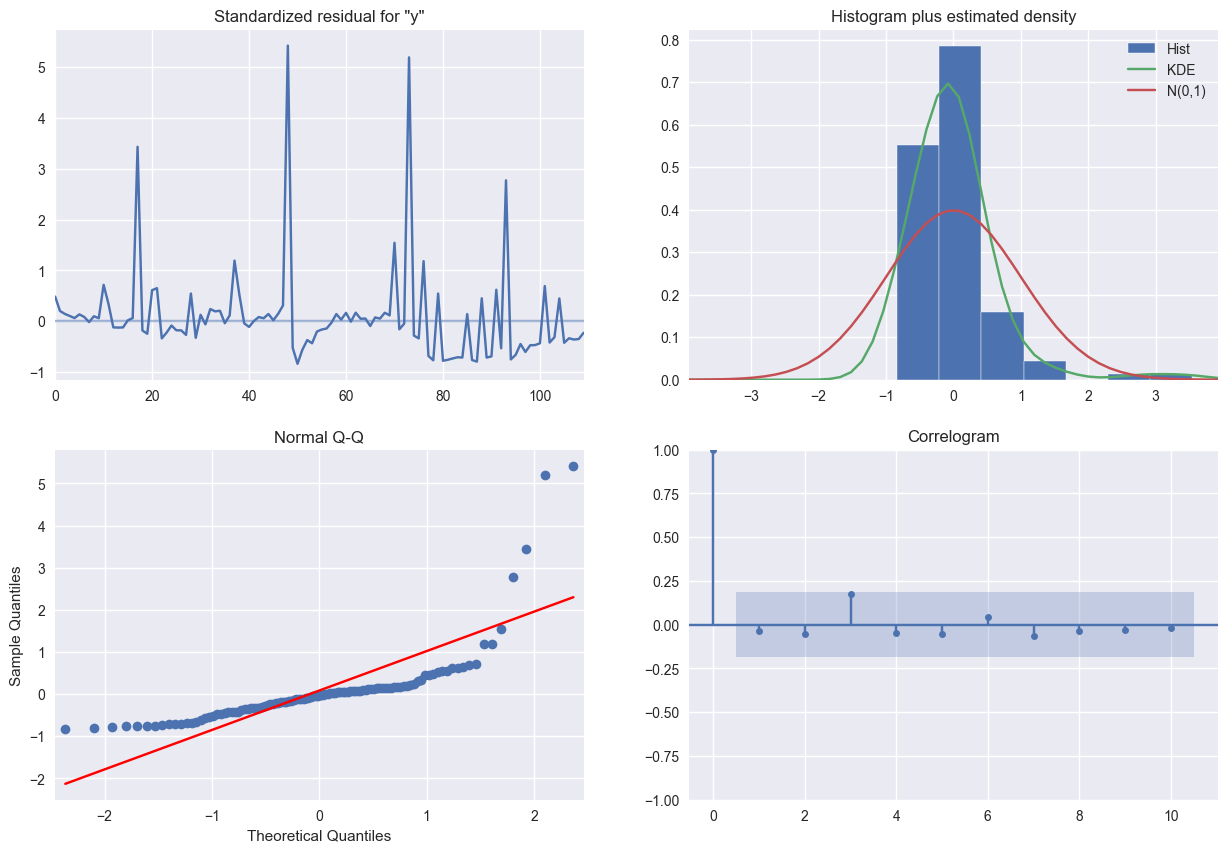

In [84]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

#### Durbin Watson Test for Autocorrelation among residuals

In [85]:
out = durbin_watson(results.resid)
description['Autocorrelation_SARIMA']=out
print("Autocorrelation among residual for {}".format(other_car_item.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 2.05


#### Error Metrics

In [86]:
description['MAPE_SARIMA']=MAPE(test.flatten(),forecast)
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))

For SKU: 12844067194 MAPE is : 67.82628444574819


In [87]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['RMSE_SARIMA']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 35738.17.
Root Mean Squared Error is :9455.09


## Capping the outliers to upper IQR and Creating model

In [88]:
def get_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    outliers=df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))][[df.columns[0]]].dropna().values.flatten()
    return outliers

In [89]:
def cap_outlier(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    upper_limit=Q3+1.5*IQR
    df['Capped Data']=df[df.columns[0]].apply(lambda x:upper_limit.values[0] if x>=upper_limit.values[0] else x)
    return df

In [90]:
item_data=cap_outlier(other_car_item)

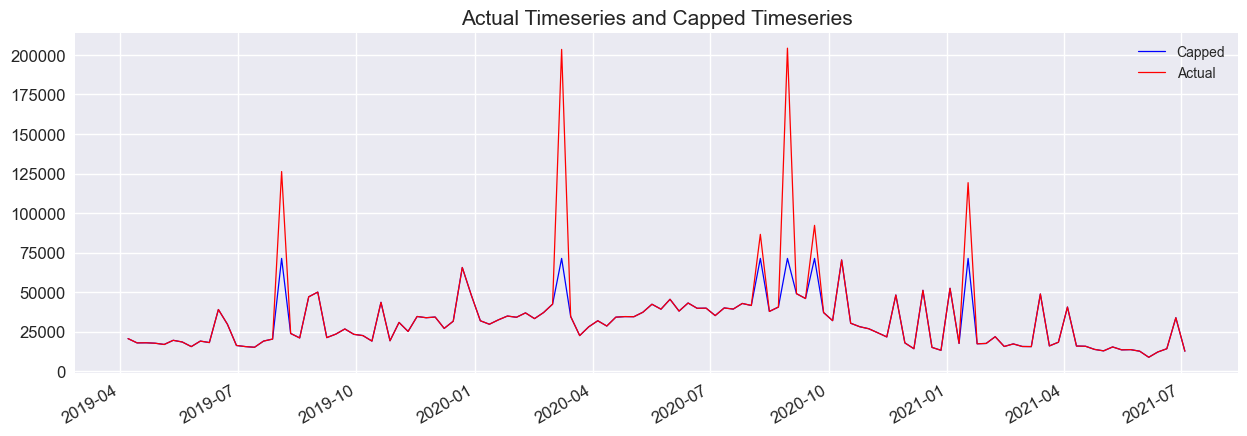

In [91]:
y1=item_data[item_data.columns[1]]
y0=item_data[item_data.columns[0]]
x=date
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title("Actual Timeseries and Capped Timeseries",fontsize=15)
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Capped','Actual'])
plt.show()

### Forecasting using ARIMA

#### Model Fitting

##### Create Training and Test

In [92]:
train = item_data[[item_data.columns[1]]].values[:-8]
test = item_data[[item_data.columns[1]]].values[-8:]

In [93]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # number of observations per seasonal cycle
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2398.856, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2456.527, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2428.601, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2397.522, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2454.532, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2398.880, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2400.390, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2395.305, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2396.703, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2396.723, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2426.599, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2398.307, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.453 seconds


In [94]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1195.653
Date:                Fri, 12 Jul 2024   AIC                           2395.305
Time:                        03:28:15   BIC                           2400.688
Sample:                             0   HQIC                          2397.488
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8249      0.061    -13.513      0.000      -0.945      -0.705
sigma2      2.285e+08   1.08e-11   2.11e+19      0.000    2.28e+08    2.28e+08
Ljung-Box (L1) (Q):                   0.49   Jarque-

In [95]:
description['ARIMA_capped']=model.order

#### Forecasting Time Series

In [96]:
forecast=model.predict(n_periods=8)

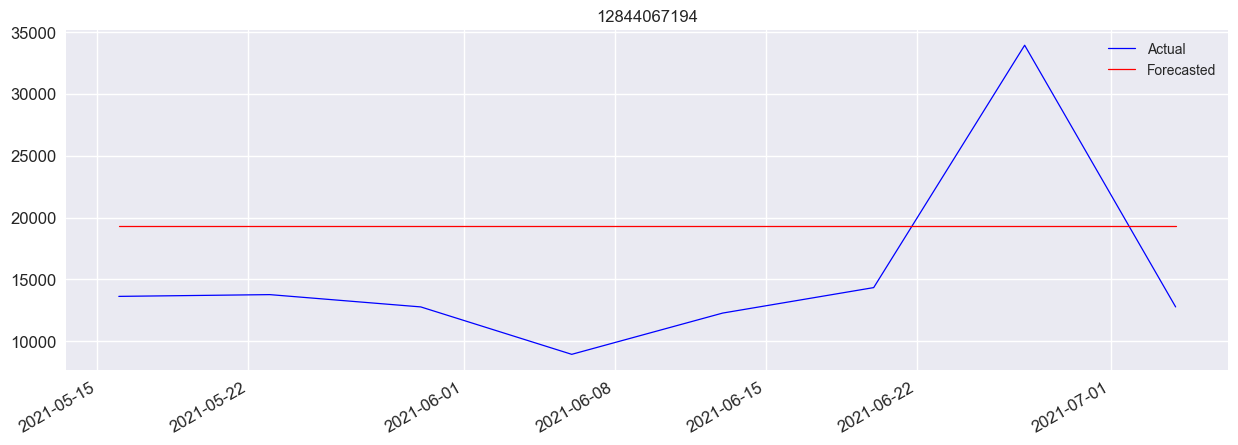

In [97]:
y1=test.flatten()
y0=forecast
x=date[-8:]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title(item_data.columns[0])
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Forecasted'],loc='best')
plt.show()

#### Diagonostic Checking

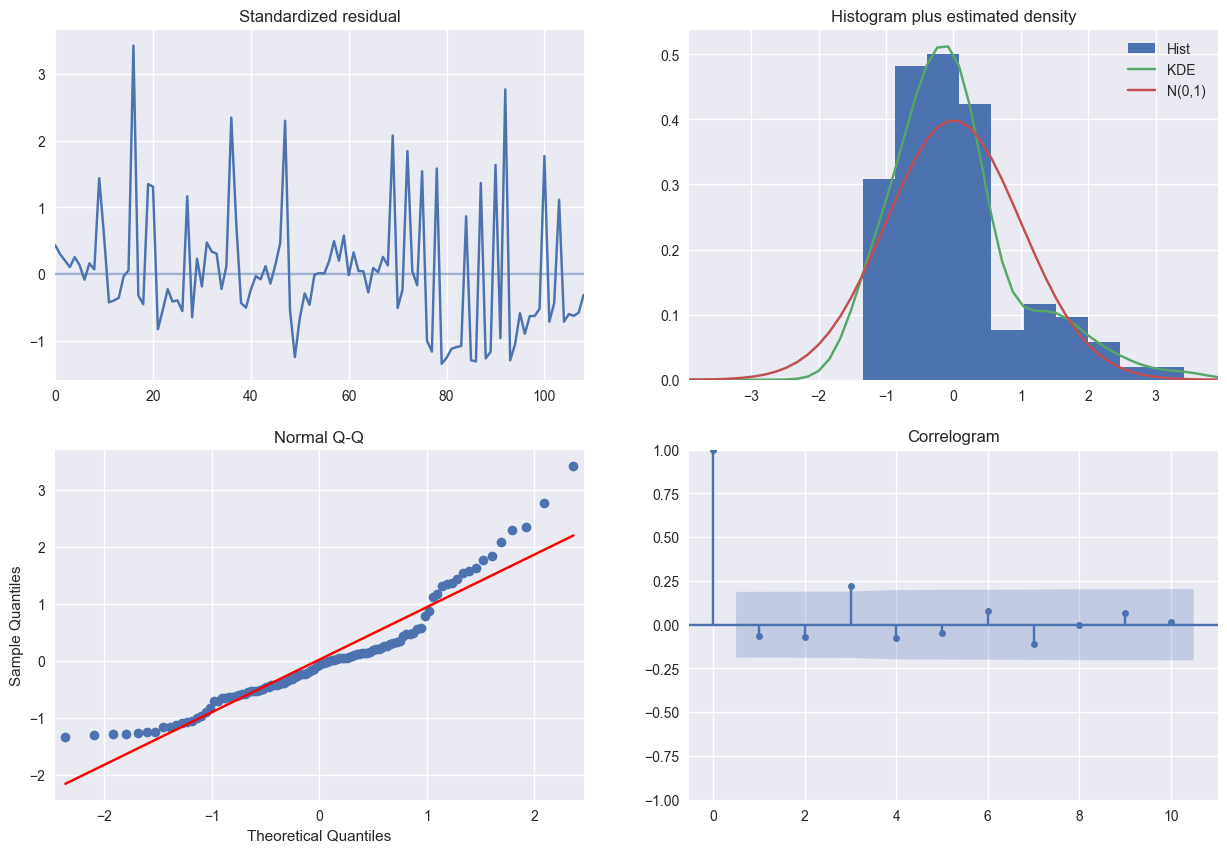

In [98]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

#### Durbin Watson Test for Autocorrelation among residuals

In [99]:
out = durbin_watson(model.resid())
description['Autocorrelation_ARIMA_capped']=out
print("Autocorrelation among residual for {}".format(other_car_item.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 2.09


#### Error Metrics

In [100]:
description['ARIMA_capped_MAPE']=MAPE(test.flatten(),forecast)
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))

For SKU: 12844067194 MAPE is : 54.55426514340764


In [101]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['ARIMA_capped_RMSE']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 32067.63.
Root Mean Squared Error is :8257.84


### GridSearch for SARIMAX model

In [102]:
res=pd.DataFrame()
for seasonality in [4,12]:

    # Note: higher numbers will result in code taking much longer to run
    # Here we have it set to test p,d,q each = 0, 1 & 2

    # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
    d=range(0,2)
    p = q = range(0,2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    # Note: here we have 12 in the 's' position as we have monthly data
    # You'll want to change this according to your time series' frequency
    pdqs = [(x[0], x[1], x[2], seasonality) for x in list(itertools.product(p, d, q))]
    k=sarimax_gridsearch(train, pdq, pdqs)
    res=pd.concat([res,k],axis=0,ignore_index=True)

SARIMAX (0, 0, 0) x (0, 0, 0, 4) : BIC Calculated =2621.663646629826, MAPE Calculated= 100.0
SARIMAX (0, 0, 0) x (0, 0, 1, 4) : BIC Calculated =2583.0564559767, MAPE Calculated= 68.10454102388994
SARIMAX (0, 0, 0) x (0, 1, 0, 4) : BIC Calculated =2398.1146313102336, MAPE Calculated= 46.89772778958962
SARIMAX (0, 0, 0) x (0, 1, 1, 4) : BIC Calculated =2361.586144758919, MAPE Calculated= 43.96883979796421
SARIMAX (0, 0, 0) x (1, 0, 0, 4) : BIC Calculated =2486.757462747734, MAPE Calculated= 43.210742020790555
SARIMAX (0, 0, 0) x (1, 0, 1, 4) : BIC Calculated =2454.196087353083, MAPE Calculated= 41.1528118534012
SARIMAX (0, 0, 0) x (1, 1, 0, 4) : BIC Calculated =2372.673843260459, MAPE Calculated= 44.14158331155957
SARIMAX (0, 0, 0) x (1, 1, 1, 4) : BIC Calculated =2365.3393997208427, MAPE Calculated= 43.61611460348452
SARIMAX (0, 0, 1) x (0, 0, 0, 4) : BIC Calculated =2574.989588407889, MAPE Calculated= 66.9575816781233
SARIMAX (0, 0, 1) x (0, 0, 1, 4) : BIC Calculated =2567.461007426799

In [103]:
res.sort_values(by='mape',inplace=True)
res

,pdq,pdqs,bic,mape
0,"(1, 0, 1)","(1, 0, 0, 4)",2430.908,33.326
5,"(1, 0, 1)","(0, 0, 1, 12)",2431.373,33.329
1,"(1, 0, 1)","(0, 0, 1, 4)",2430.898,33.341
6,"(1, 0, 1)","(1, 0, 0, 12)",2431.399,33.368
7,"(1, 0, 1)","(1, 0, 1, 12)",2435.900,33.388
2,"(1, 0, 1)","(0, 0, 0, 4)",2426.803,33.507
8,"(1, 0, 1)","(0, 0, 0, 12)",2426.803,33.507
3,"(1, 0, 1)","(1, 0, 1, 4)",2436.024,33.576
9,"(0, 1, 1)","(1, 0, 1, 12)",2409.083,35.052
4,"(0, 1, 1)","(1, 0, 0, 4)",2404.847,35.269


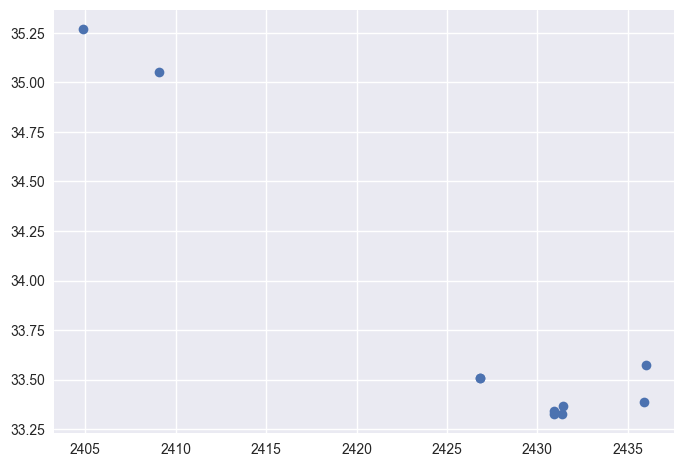

In [104]:
plt.plot(res['bic'],res['mape'],'o')

In [105]:
p,d,q=res['pdq'].iloc[0]
ps,ds,qs,ss=res['pdqs'].iloc[0]

In [106]:
print(p,d,q)
print(ps,ds,qs,ss)

1 0 1
1 0 0 4


### Forecasting using SARIMA

#### Model Fitting

In [107]:
model=sm.tsa.statespace.SARIMAX(train,order=(p,d, q),seasonal_order=(ps,ds,qs,ss))
results=model.fit()
description['SARIMA_capped']=[model.order,model.seasonal_order]

#### Forecasting Time Series

In [108]:
forecast=results.predict(start=111,end=118)

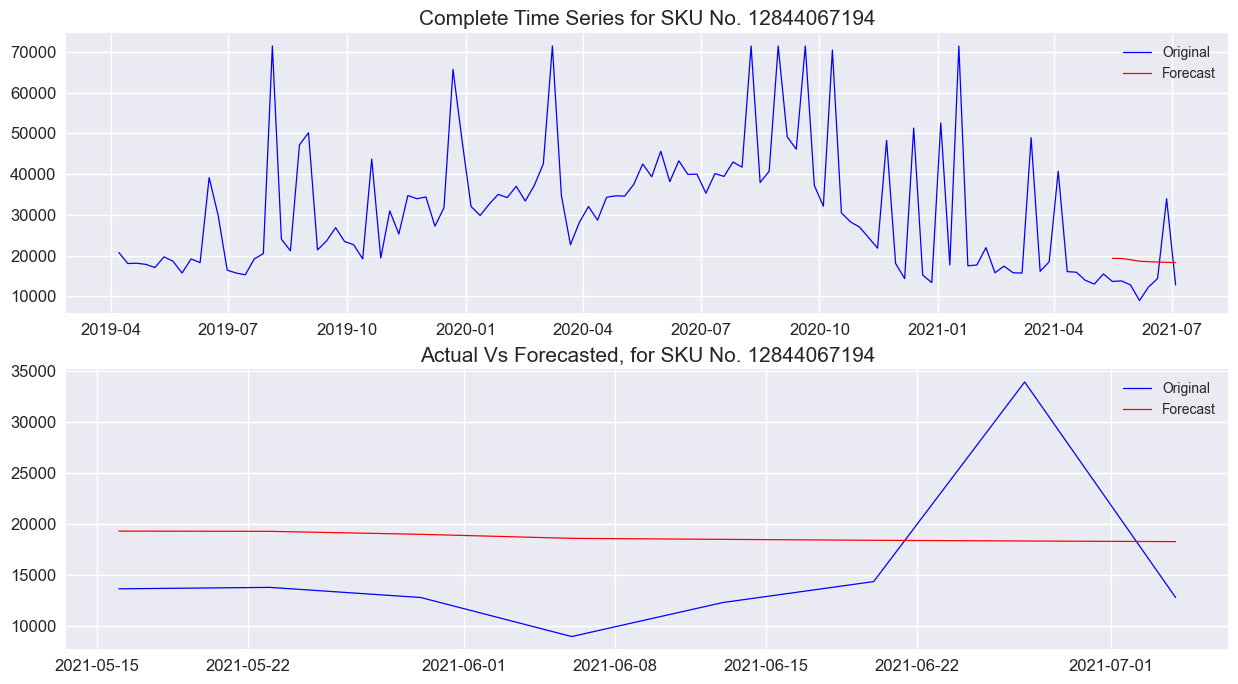

In [109]:
y1=item_data[item_data.columns[1]]
y0=forecast
x=date
y11=test.flatten()
y01=forecast
x1=date[-8:]
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(15,8))
axes[0].plot(x,y1,'-',color='blue' ,linewidth=0.9)
axes[0].plot(date[-8:],y0,'-',color='red' ,linewidth=0.9)
axes[0].set_title("Complete Time Series for SKU No. {}".format(item_data.columns[0]),fontsize=15)
axes[0].xaxis_date()
axes[0].tick_params(labelsize=12)
axes[0].legend(['Original','Forecast'])
axes[1].plot(x1,y11,'-',color='blue' ,linewidth=0.9)
axes[1].plot(x1,y01,'-',color='red' ,linewidth=0.9)
axes[1].set_title("Actual Vs Forecasted, for SKU No. {}".format(item_data.columns[0]),fontsize=15)
axes[1].xaxis_date()
axes[1].tick_params(labelsize=12)
axes[1].legend(['Original','Forecast'])
plt.show()

#### Diagonostic Checking

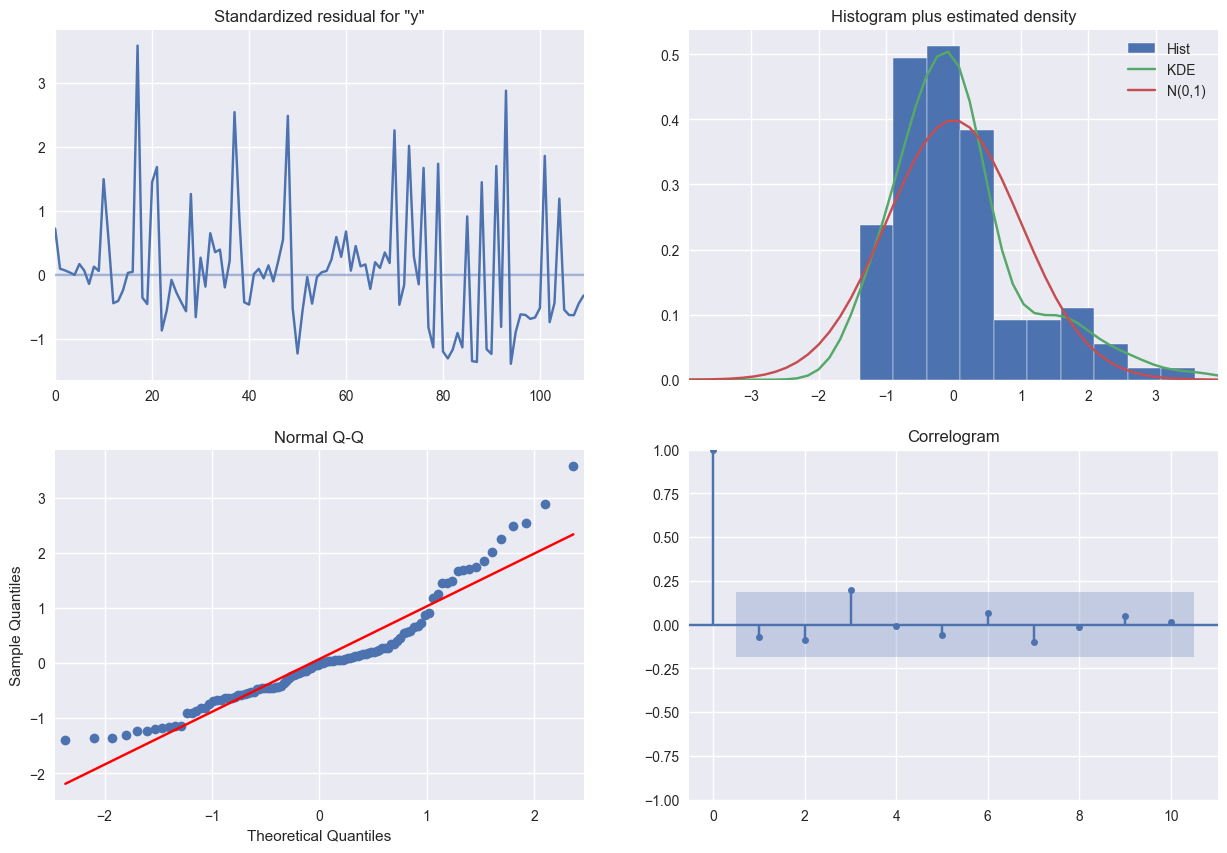

In [110]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

#### Durbin Watson Test for Autocorrelation among residuals

In [111]:
out = durbin_watson(results.resid)
description['Autocorrelation_SARIMA_capped']=out
print("Autocorrelation among residual for {}".format(other_car_item.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 2.1


#### Error Metrics

In [112]:
description['SARIMA_capped_MAPE']=MAPE(test.flatten(),forecast)
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))

For SKU: 12844067194 MAPE is : 50.69389244652663


In [113]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['SARIMA_capped_RMSE']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 32067.63.
Root Mean Squared Error is :8082.13


----------------